In [2]:
import pandas as pd

In [3]:
#Using train data and test data
data = pd.read_csv('/Users/anastasiakurakova/Desktop/Data/cirrhosis/cirrhosis_train.csv')
data.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,294,1302,C,D-penicillamine,22111,M,N,Y,N,N,6.6,1000.0,3.07,88.0,3150.0,193.00,133.0,299.0,10.9,4.0
1,267,179,D,D-penicillamine,25899,F,Y,Y,Y,Y,6.6,222.0,2.33,138.0,620.0,106.00,91.0,195.0,12.1,4.0
2,36,3611,C,Placebo,20604,F,N,N,N,N,0.3,172.0,3.39,18.0,558.0,71.30,96.0,311.0,10.6,2.0
3,184,974,D,Placebo,13736,F,N,Y,N,N,11.0,674.0,3.55,358.0,2412.0,167.40,140.0,471.0,9.8,3.0
4,170,2692,C,D-penicillamine,17774,F,N,N,N,N,1.2,390.0,3.61,32.0,1509.0,88.35,52.0,263.0,9.0,3.0


In [4]:
data.shape

(220, 20)

### TVAE is a part of Synthetic Data Vault Package

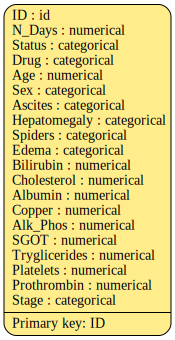

In [5]:
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data)
metadata.visualize()

In [6]:
%%time
from sdv.single_table import TVAESynthesizer
model = TVAESynthesizer(metadata, epochs=3500)
model.fit(data)

CPU times: user 28.5 s, sys: 16.7 s, total: 45.2 s
Wall time: 29.3 s


In [7]:
import plotly.express as px

loss_values = model.get_loss_values()
loss_values_reformatted = pd.melt(
    loss_values,
    id_vars=['Epoch'],
    var_name='Loss Type'
)

fig = px.line(loss_values_reformatted, x="Epoch", y="value", color="Loss Type", title='Epoch vs. Loss')
fig.show()

In [8]:
synthetic_data = model.sample(len(data))
synthetic_data.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,0,2262,C,Placebo,22213,F,N,Y,N,N,1.2,406.0,3.27,53.0,1348.4,149.33,218.0,272.0,9.9,3.0
1,1,3204,C,Placebo,12344,F,N,Y,Y,N,3.6,269.0,3.88,24.0,1120.0,114.70,85.0,118.0,11.2,4.0
2,2,321,D,Placebo,25873,M,N,Y,N,N,25.5,241.0,3.22,275.0,1444.7,200.54,128.0,257.0,12.6,4.0
3,3,967,C,Placebo,13908,F,N,Y,Y,N,1.0,320.0,4.25,81.0,1318.6,80.03,126.0,359.0,9.8,3.0
4,4,1612,C,D-penicillamine,18962,F,N,N,N,N,1.7,217.0,3.61,45.0,621.8,85.57,137.0,212.0,9.6,1.0


In [9]:
#synthetic_data.to_csv('/Users/anastasiakurakova/Desktop/Data/cirrhosis/cirrhosis_TSTR_TVAE.csv', index= False)
# Testing Data for Evaluation
X_test = pd.read_csv("/Users/anastasiakurakova/Desktop/Data/cirrhosis/cirrhosis_test.csv")

In [13]:
# Find common duplicate rows between testing and synthetic data
common_duplicates = pd.merge(X_test, synthetic_data, how='inner')
new = common_duplicates.drop_duplicates()
# Print the common duplicate rows
print("Common Duplicate Rows:")
print(common_duplicates)
print(new)

Common Duplicate Rows:
Empty DataFrame
Columns: [ID, N_Days, Status, Drug, Age, Sex, Ascites, Hepatomegaly, Spiders, Edema, Bilirubin, Cholesterol, Albumin, Copper, Alk_Phos, SGOT, Tryglicerides, Platelets, Prothrombin, Stage]
Index: []
Empty DataFrame
Columns: [ID, N_Days, Status, Drug, Age, Sex, Ascites, Hepatomegaly, Spiders, Edema, Bilirubin, Cholesterol, Albumin, Copper, Alk_Phos, SGOT, Tryglicerides, Platelets, Prothrombin, Stage]
Index: []


### Data Evaluation Using SDV Library

In [14]:
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality

diagnostic = run_diagnostic(
    real_data=X_test,
    synthetic_data=synthetic_data,
    metadata=metadata
)

quality_report = evaluate_quality(
    X_test,
    synthetic_data,
    metadata
)

Generating report ...
(2/2) Evaluating Data Structure: : 100%|██████████| 1/1 [00:00<00:00, 865.16it/s]

Overall Score: 99.6%

Properties:
- Data Validity: 99.2%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 190/190 [00:01<00:00, 159.77it/s]

Overall Score: 82.99%

Properties:
- Column Shapes: 85.4%
- Column Pair Trends: 80.58%


In [15]:
quality_report.get_details('Column Shapes')

,Column,Metric,Score
0,N_Days,KSComplement,0.907468
1,Status,TVComplement,0.936364
2,Drug,TVComplement,0.905195
3,Age,KSComplement,0.854870
4,Sex,TVComplement,0.912013
5,Ascites,TVComplement,0.956169
6,Hepatomegaly,TVComplement,0.863961
7,Spiders,TVComplement,0.931494
8,Edema,TVComplement,0.912338
9,Bilirubin,KSComplement,0.807143


### Calculate Range Coverage and KSComplement for Numerical Variables

In [16]:
from sdmetrics.single_column import RangeCoverage, KSComplement
for i in ['Bilirubin','Albumin']:
  range_cov = RangeCoverage.compute(
      real_data=X_test[i],
      synthetic_data=synthetic_data[i]
  )
  ks = KSComplement.compute(
      real_data=X_test[i],
      synthetic_data=synthetic_data[i]
  )
  print(f"Range coverage for {i} is: {range_cov}")
  print(f"KSComplement for {i} is: {ks}")

Range coverage for Bilirubin is: 0.9097472924187726
KSComplement for Bilirubin is: 0.8071428571428572
Range coverage for Albumin is: 0.9202453987730062
KSComplement for Albumin is: 0.836038961038961


### Calculate Category Coverage and TVComplement for Categorical Variables

In [17]:

from sdmetrics.single_column import CategoryCoverage, TVComplement
for i in ['Status','Stage']:
  cat_cov = CategoryCoverage.compute(
    real_data=X_test[i],
    synthetic_data=synthetic_data[i]
  )
  tv = TVComplement.compute(
      real_data=X_test[i],
      synthetic_data=synthetic_data[i]
  )
  print(f"Category coverage for {i} is: {cat_cov}")
  print(f"TVComplement for {i} is: {tv}")

Category coverage for Status is: 1.0
TVComplement for Status is: 0.9363636542207788
Category coverage for Stage is: 1.0
TVComplement for Stage is: 0.9340909090909091


### Evaluation using Table Evaluator

(56, 20) (220, 20)


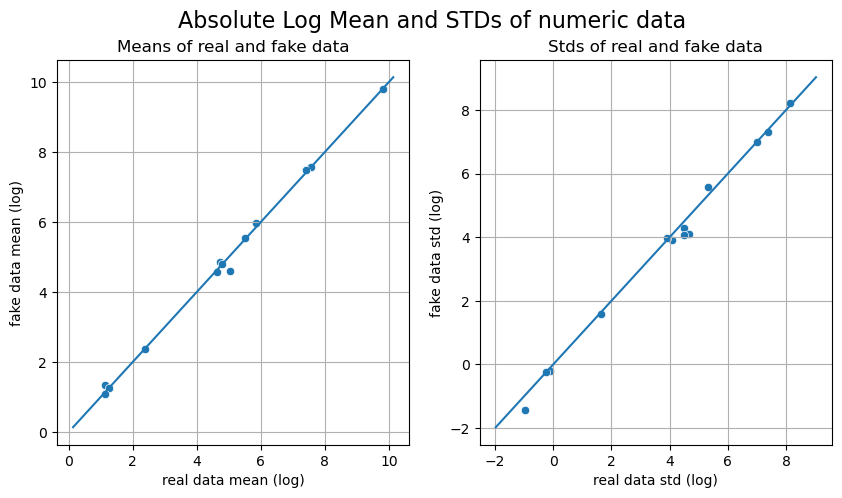

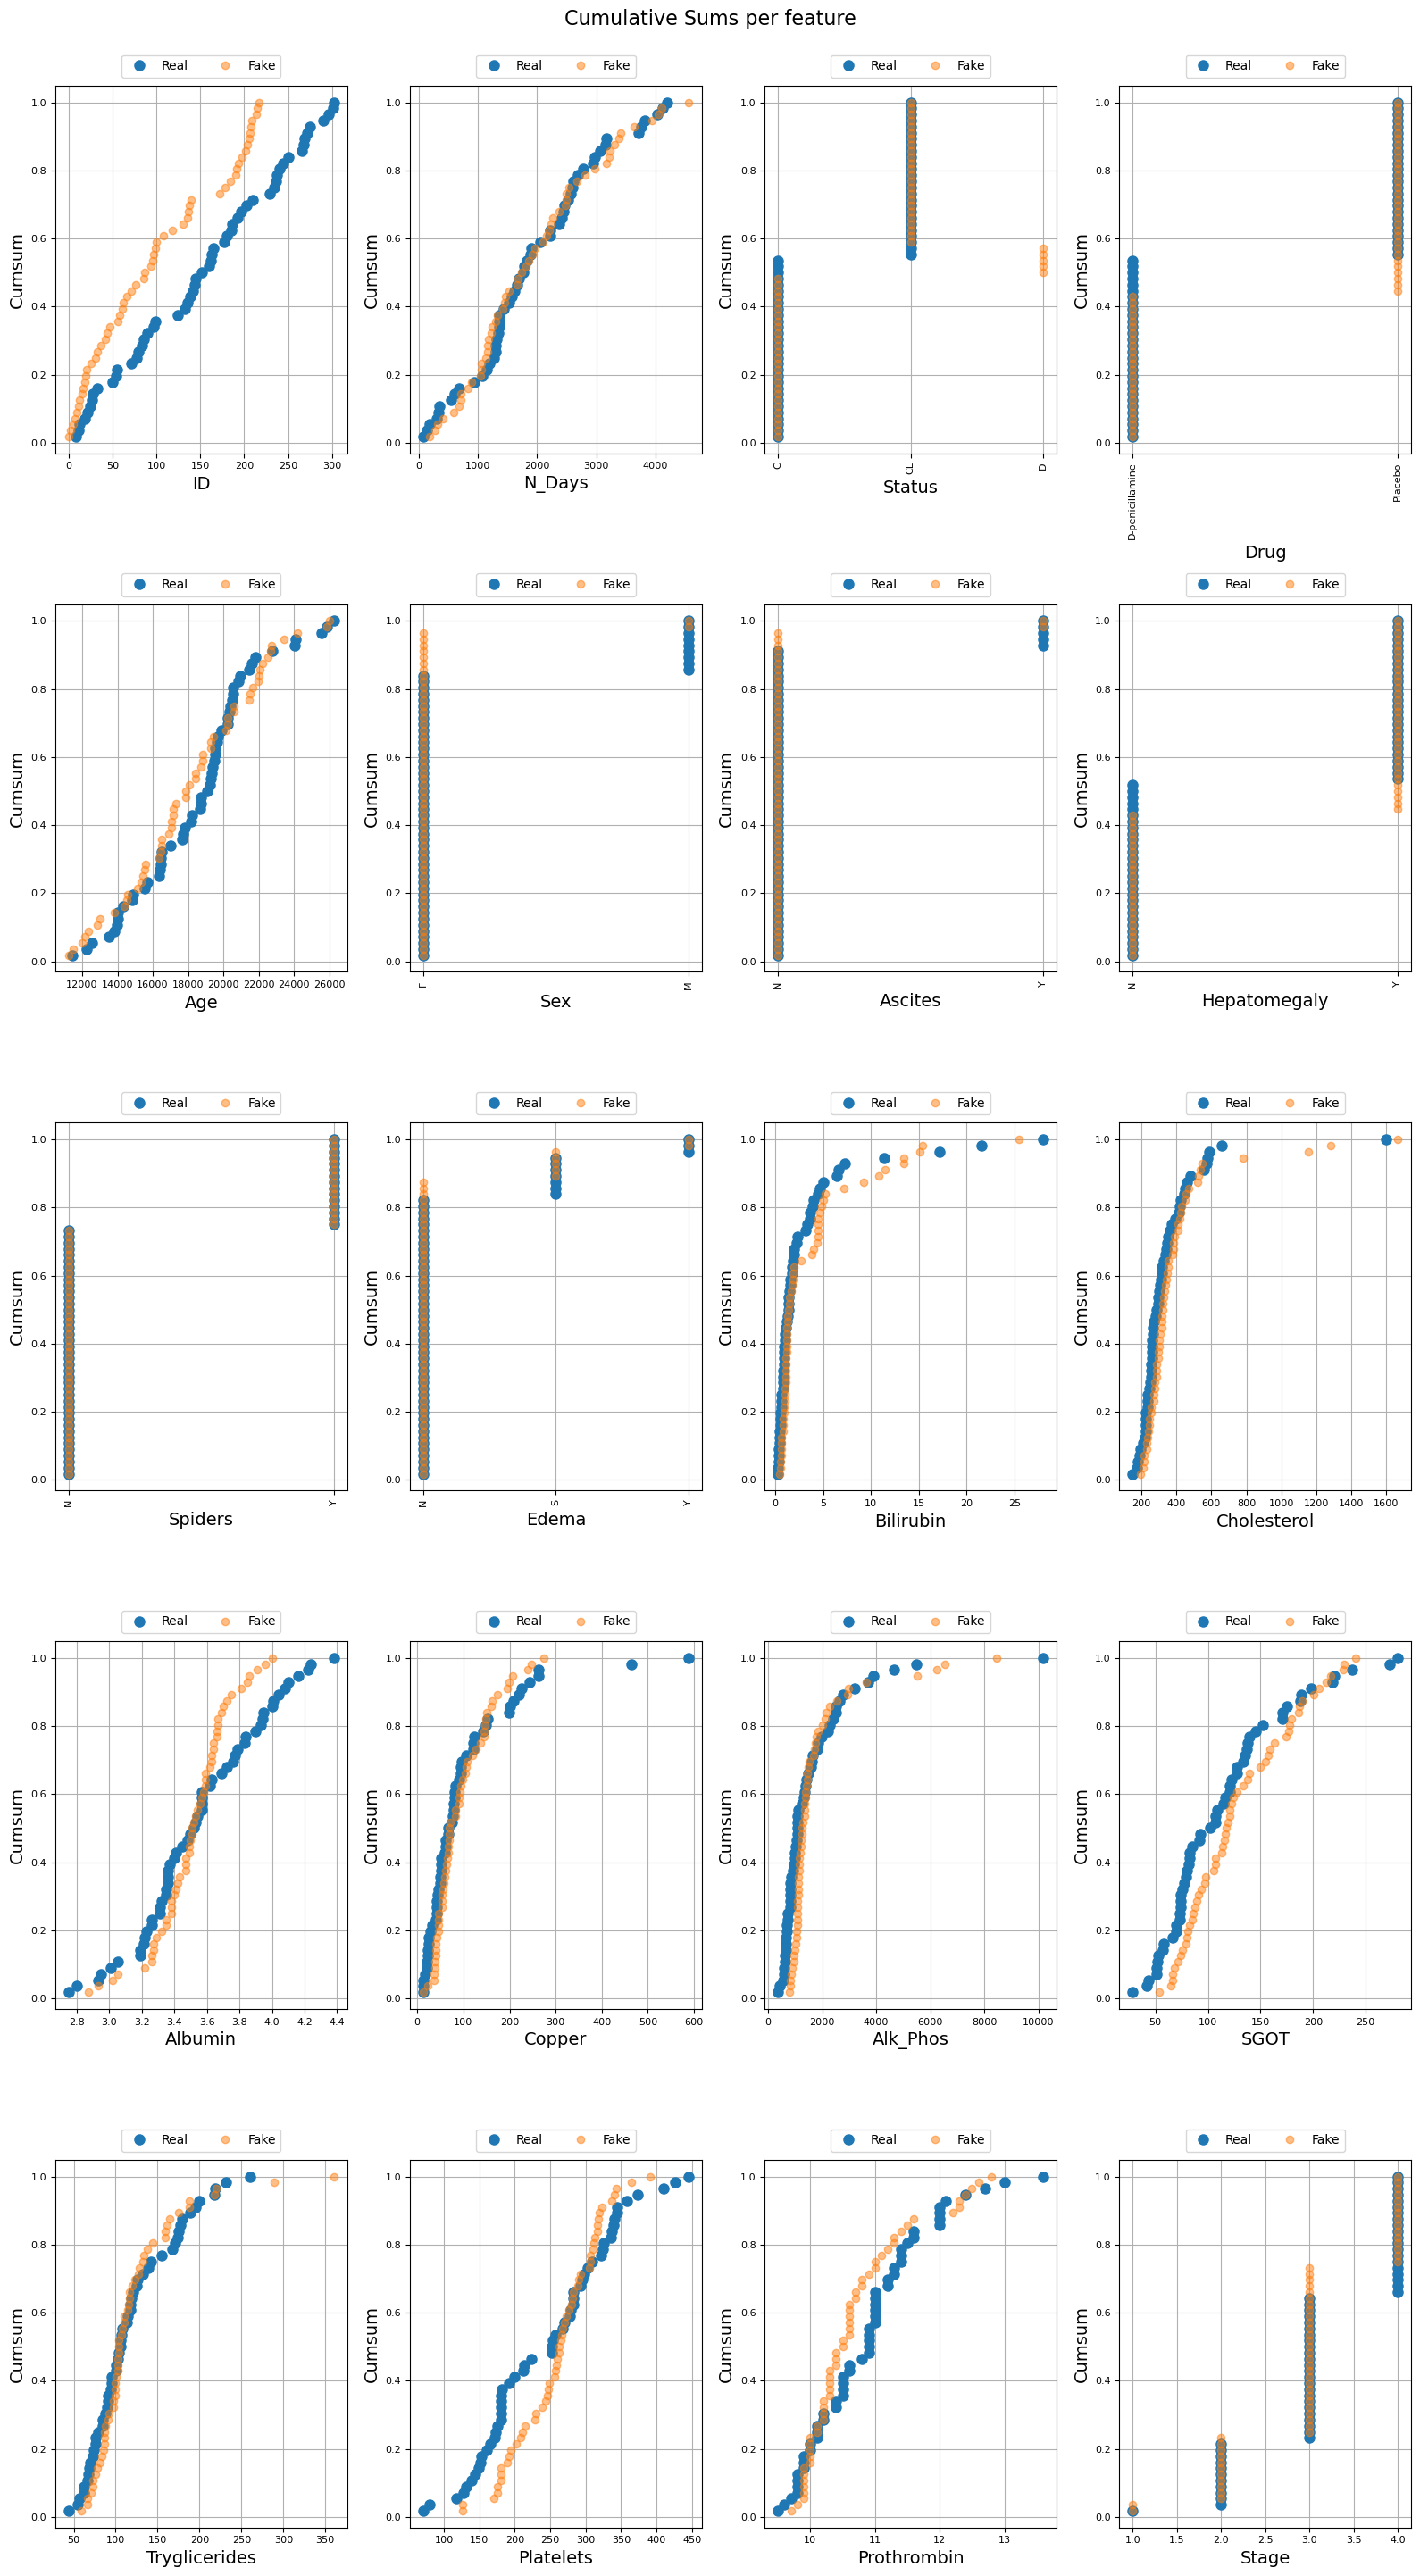

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/table_evaluator/table_evaluator.py:182: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/table_evaluator/table_evaluator.py:182: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/table_evaluator/table_evaluator.py:182: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/table_evaluator/table_evaluator.py:182: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/Users/anastasiakurakova/min

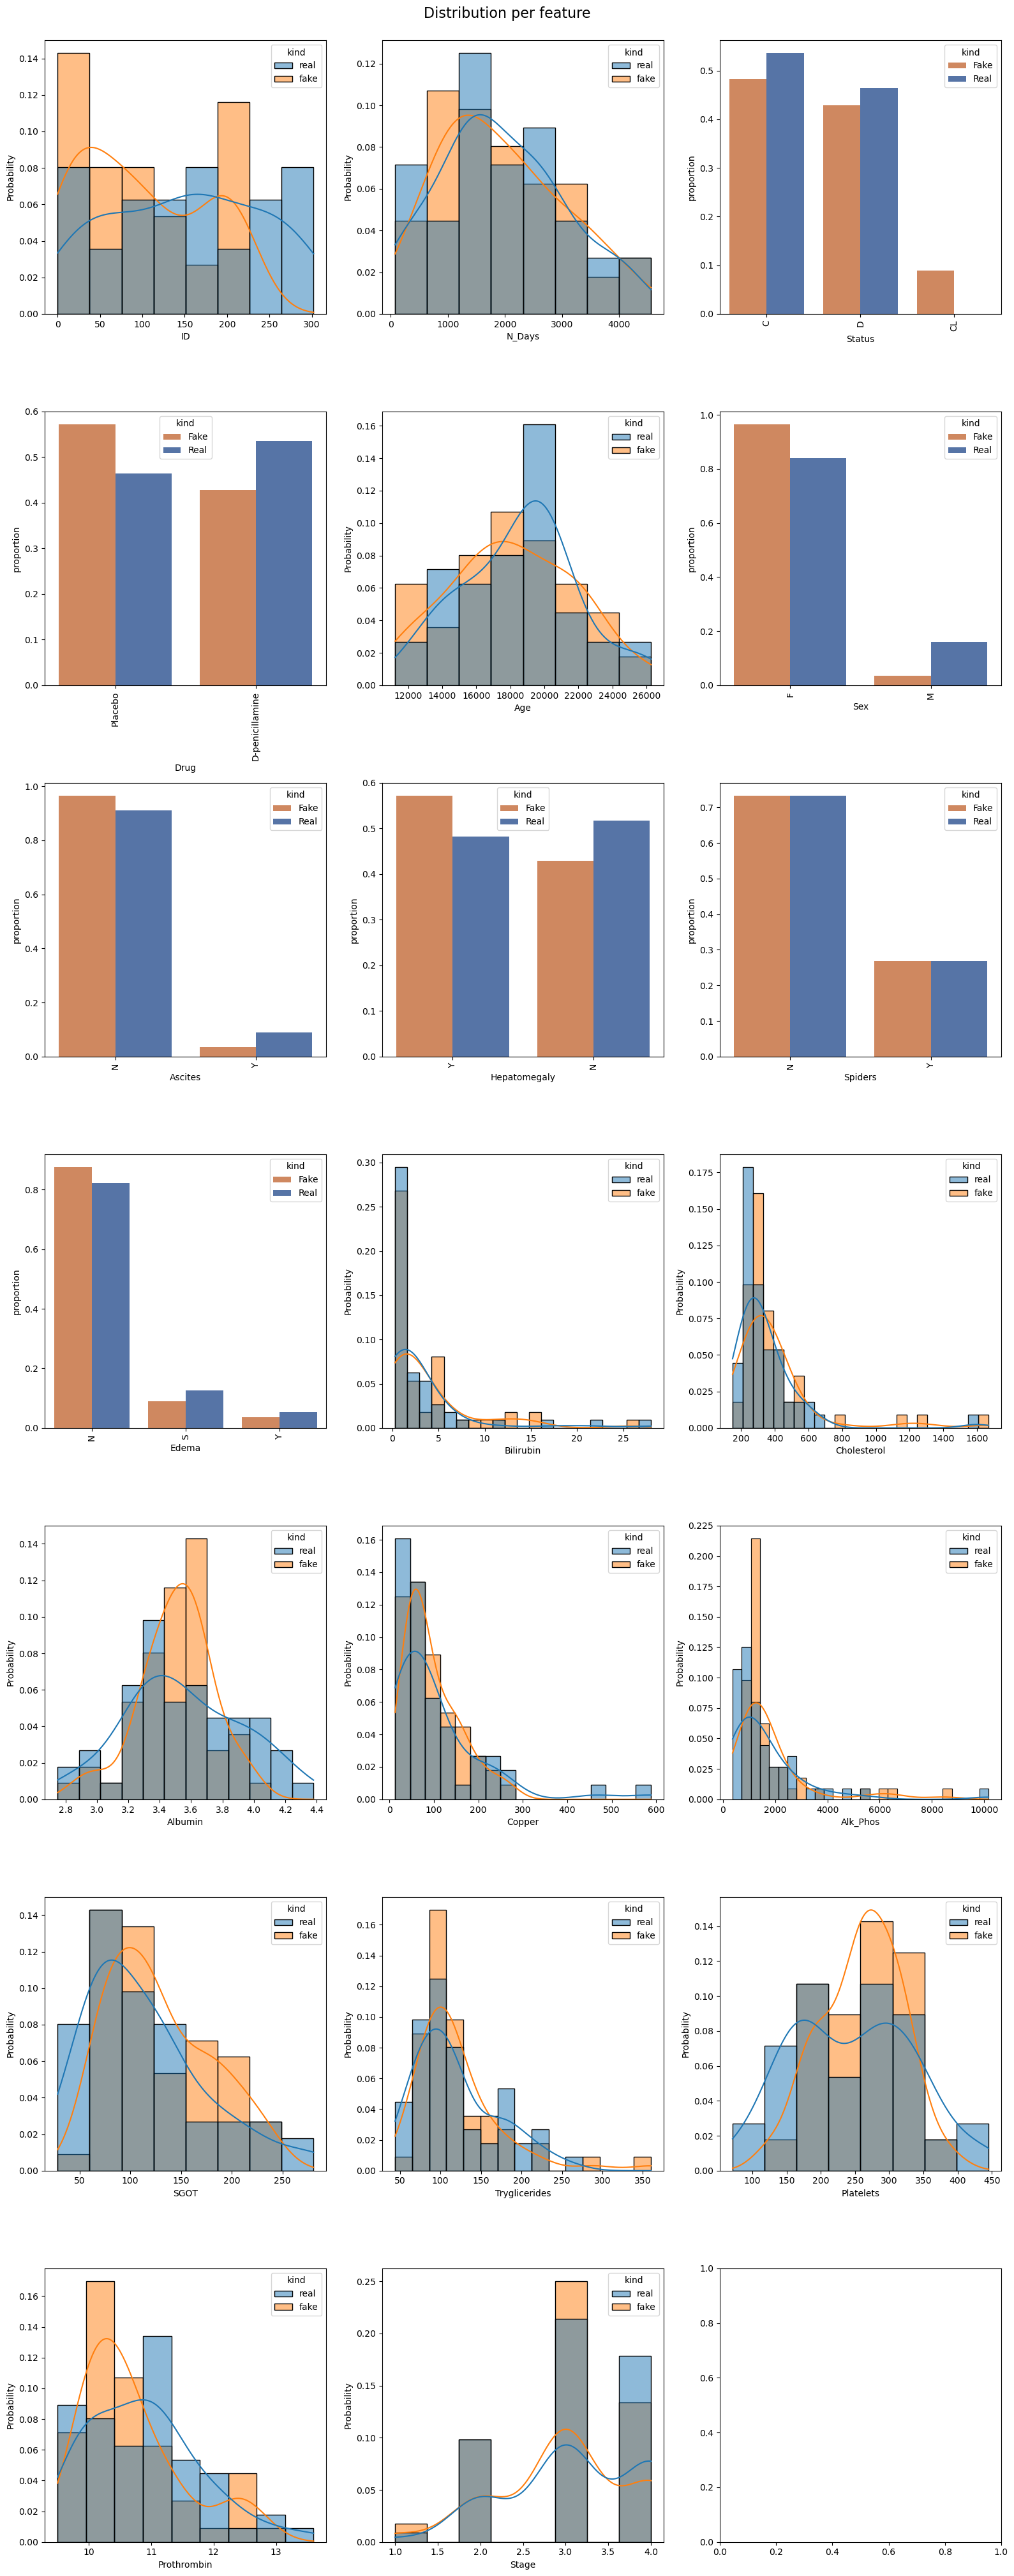

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/dython/nominal.py:704: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/dython/nominal.py:705: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/dython/nominal.py:704: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/dython

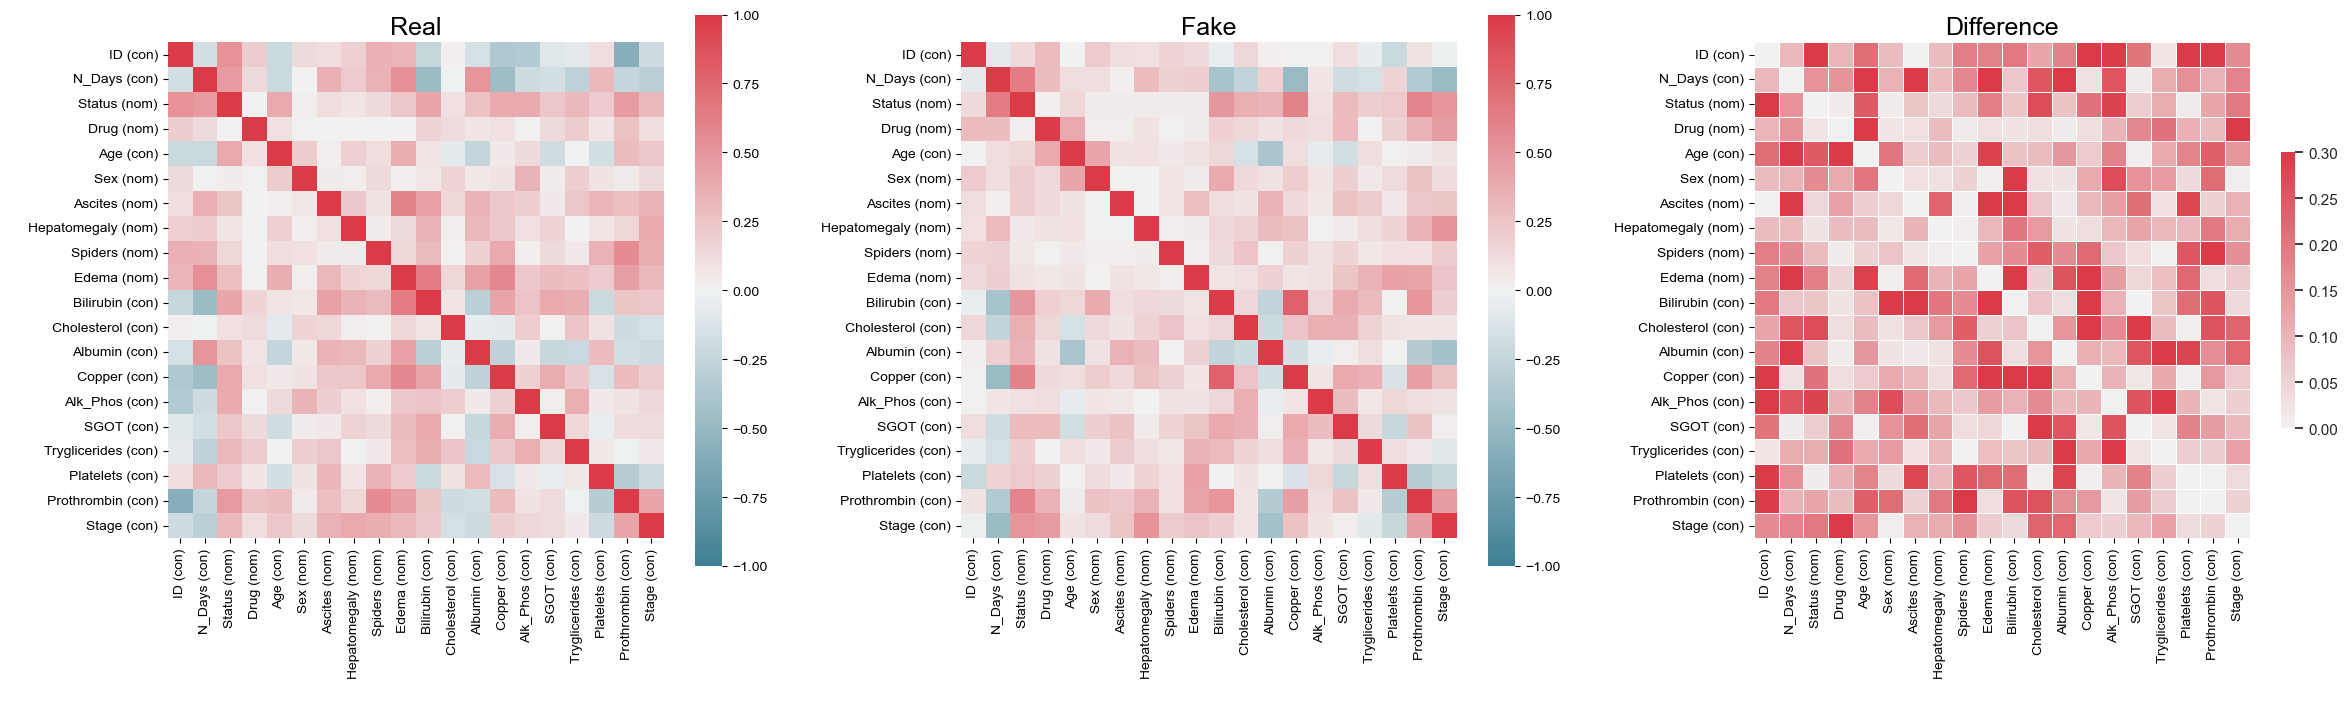

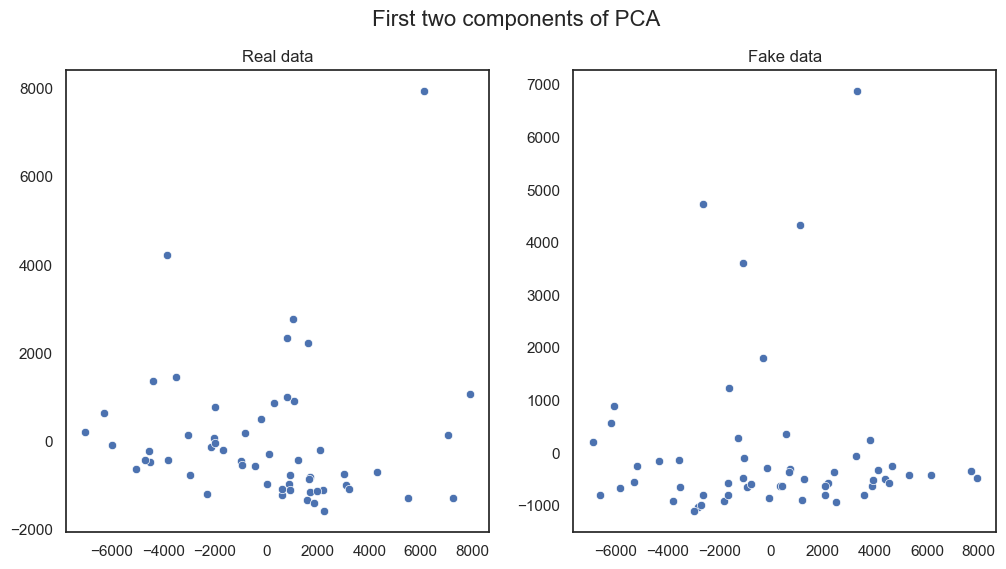

In [18]:
from table_evaluator import TableEvaluator
print(X_test.shape,synthetic_data.shape)
table_evaluator = TableEvaluator(X_test,synthetic_data)
table_evaluator.visual_evaluation()

In [19]:
table_evaluator.evaluate(target_col='Status')

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/dython/nominal.py:704: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/dython/nominal.py:705: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/dython/nominal.py:704: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/dython


Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.3333   0.5833              0.3333
DecisionTreeClassifier_real   0.5833   0.3333              0.3333
LogisticRegression_fake       0.2500   0.4167              0.2632
LogisticRegression_real       0.8333   0.4167              0.2000
MLPClassifier_fake            0.3333   0.5833              0.0000
MLPClassifier_real            0.5833   0.0000              0.0000
RandomForestClassifier_fake   0.3333   0.5833              0.2632
RandomForestClassifier_real   0.8333   0.2500              0.2000

Privacy results:
                                         result
Duplicate rows between sets (real/fake)  (0, 0)
nearest neighbor mean                    2.9918
nearest neighbor std                     0.6110

Miscellaneous results:
                                  Result
Column Cor

### Looking at Wasserstein Distance for Testing vs Synthetic and Testing vs Training

In [21]:
from scipy.stats import wasserstein_distance
wasserstein_distances = {}
for column in X_test.columns[10:]:
    wasserstein_dist = wasserstein_distance(X_test[column], synthetic_data[column])
    wasserstein_distances[column] = wasserstein_dist
# Print Wasserstein distances for each feature
for column, distance in wasserstein_distances.items():
    print(f'Comparing Testing data and Synthetic Data {column}: {distance}')

Comparing Testing data and Synthetic Data Bilirubin: 0.9430844155844162
Comparing Testing data and Synthetic Data Cholesterol: 47.43766233766231
Comparing Testing data and Synthetic Data Albumin: 0.10287337662337662
Comparing Testing data and Synthetic Data Copper: 25.012337662337668
Comparing Testing data and Synthetic Data Alk_Phos: 323.76720779220784
Comparing Testing data and Synthetic Data SGOT: 20.049922077922076
Comparing Testing data and Synthetic Data Tryglicerides: 10.920129870129864
Comparing Testing data and Synthetic Data Platelets: 21.20227272727273
Comparing Testing data and Synthetic Data Prothrombin: 0.20051948051948057
Comparing Testing data and Synthetic Data Stage: 0.08474025974025978


In [22]:
wasserstein_distances = {}
for column in X_test.columns[10:]:
    wasserstein_dist = wasserstein_distance(X_test[column], data[column])
    wasserstein_distances[column] = wasserstein_dist
# Print Wasserstein distances for each feature
for column, distance in wasserstein_distances.items():
    print(f'Comparing Testing data and Training Data {column}: {distance}')

Comparing Testing data and Training Data Bilirubin: 0.6394480519480523
Comparing Testing data and Training Data Cholesterol: 40.025974025974
Comparing Testing data and Training Data Albumin: 0.07491233766233764
Comparing Testing data and Training Data Copper: 13.235714285714295
Comparing Testing data and Training Data Alk_Phos: 443.8344155844153
Comparing Testing data and Training Data SGOT: 14.910636363636364
Comparing Testing data and Training Data Tryglicerides: 10.212337662337656
Comparing Testing data and Training Data Platelets: 21.6775974025974
Comparing Testing data and Training Data Prothrombin: 0.24383116883116884
Comparing Testing data and Training Data Stage: 0.10681818181818184


### Looking at KL Divergence for Testing vs Synthetic and Testing vs Training

In [25]:
# Calculate KL Divergence for each feature
from scipy.stats import entropy
kl_divergences = {}
for column in X_test.columns[10:]:
    kl_divergence = entropy(X_test[column], synthetic_data[:56][column])
    kl_divergences[column] = kl_divergence

# Print KL Divergences for each feature
for column, divergence in kl_divergences.items():
    print(f'For Testing vs Synthetic Data {column}: {divergence}')

For Testing vs Synthetic Data Bilirubin: 1.333472813134001
For Testing vs Synthetic Data Cholesterol: 0.2367298577200792
For Testing vs Synthetic Data Albumin: 0.00968040391783888
For Testing vs Synthetic Data Copper: 0.598248521475037
For Testing vs Synthetic Data Alk_Phos: 0.340485462080282
For Testing vs Synthetic Data SGOT: 0.1605383703363709
For Testing vs Synthetic Data Tryglicerides: 0.11913857519550601
For Testing vs Synthetic Data Platelets: 0.11097045895233291
For Testing vs Synthetic Data Prothrombin: 0.006237606966865394
For Testing vs Synthetic Data Stage: 0.09304598911691736


In [26]:
# Calculate KL Divergence for each feature
from scipy.stats import entropy
kl_divergences = {}
for column in X_test.columns[10:]:
    kl_divergence = entropy(X_test[column], data[:56][column])
    kl_divergences[column] = kl_divergence

# Print KL Divergences for each feature
for column, divergence in kl_divergences.items():
    print(f'For Training vs Testing Data {column}: {divergence}')

For Training vs Testing Data Bilirubin: 1.4732715801585026
For Training vs Testing Data Cholesterol: 0.2917327081936546
For Training vs Testing Data Albumin: 0.008788944578457476
For Training vs Testing Data Copper: 0.9832247164200608
For Training vs Testing Data Alk_Phos: 0.45457853945850846
For Training vs Testing Data SGOT: 0.21134063569227338
For Training vs Testing Data Tryglicerides: 0.14009786597036217
For Training vs Testing Data Platelets: 0.1610055800360398
For Training vs Testing Data Prothrombin: 0.009636689035554875
For Training vs Testing Data Stage: 0.0836247320860429


In [20]:
# Wasn't used in the paper
from scipy.stats import pearsonr
# Calculate Pearson correlation coefficient for each feature
pearson_correlations = {}
for column in X_test.columns[10:]:
    correlation, _ = pearsonr(X_test[column], synthetic_data[column][:56])
    pearson_correlations[column] = correlation

# Print Pearson correlation coefficients for each feature
for column, correlation in pearson_correlations.items():
    print(f'{column}: {correlation}')

Bilirubin: -0.030227044995267523
Cholesterol: -0.08463618212136653
Albumin: 0.0474858379522857
Copper: -0.022724759876302764
Alk_Phos: 0.460187969408585
SGOT: 0.09673702487134898
Tryglicerides: 0.07948187652440977
Platelets: 0.0636816650049261
Prothrombin: -0.10577424687943533
Stage: -0.2664693550105966


In [27]:
# Check for MSE and r2
from sklearn.metrics import mean_squared_error, r2_score
# Calculate MSE between testing_data and real_data
mse_real = mean_squared_error(X_test['Cholesterol'], data[:len(X_test)]['Cholesterol'])
print("MSE between Testing Data and Real Data:", mse_real)

# Calculate MSE between testing_data and synthetic_data
mse_synthetic = mean_squared_error(X_test['Cholesterol'], synthetic_data[:len(X_test)]['Cholesterol'])
print("MSE between Testing Data and Synthetic Data:", mse_synthetic)

# Calculate R-squared (R2) score
r2 = r2_score(X_test['Cholesterol'], data[:len(X_test)]['Cholesterol'])
print("R-squared Score (between Testing Data and Real Data):", r2)

r2 = r2_score(X_test['Cholesterol'], synthetic_data[:len(X_test)]['Cholesterol'])
print("R-squared Score (between Testing Data and Synthetic Data):", r2)

MSE between Testing Data and Real Data: 131227.01785714287
MSE between Testing Data and Synthetic Data: 96409.25
R-squared Score (between Testing Data and Real Data): -2.1461407110624195
R-squared Score (between Testing Data and Synthetic Data): -1.3113919016142956


In [106]:
# Find common duplicate rows between df1 and df2
common_duplicates = pd.merge(X_test, synthetic_data, how='inner')
#new = common_duplicates.drop_duplicates()
# Print the common duplicate rows
print("Common Duplicate Rows:")
print(common_duplicates)
#print(new)

Common Duplicate Rows:
Empty DataFrame
Columns: [ID, N_Days, Status, Drug, Age, Sex, Ascites, Hepatomegaly, Spiders, Edema, Bilirubin, Cholesterol, Albumin, Copper, Alk_Phos, SGOT, Tryglicerides, Platelets, Prothrombin, Stage]
Index: []
